# Cloud Computing Project 2
## Dynamic Web Scraping
### Giuliano Oscar Stefanelli

<div class="alert alert-warning"> <b>NOTE:</b> I have decided to perform this project in two ways: 
    
    1. While being logged into LinkedIn in order to retrieve all the information the project instructions are asking for. Hence, I will use a fake account to access the platform and perform webscraping. However, for security porpuses, I will not share the credentials of this account. Hence, if you wish to run the logged-in solution, you would have to create a new LinkedIn account.

    2. Since LinkedIn randomly asks to verify the identity through a code or image recognition, we decided to include a version of our code that you can perform while being logged out. However, with the logged out version we are not able to collect all the information requested. In case LinkedIn asks you to verify your identity during the login phase, please use this simpler version.
    
    3. If you wish to run the code, we would advise you to restart the kernel.

</div>

# 1) Logged-in Solution

## Setting up the environment

Please, make sure to have installed all the necessary libraries (Selenium and Webdriver-manager). 


Next, we have to import some libraries:
- Time: while it is not illegal to scrape LinkedIn (hiQ Labs v. LinkedIn, 2022), the tech giant is making scraping its data very difficult. We will use the time library to set our code to sleep to mask the fact that a computer is doing webscraping.


- Selenium: to acess all the data requested, we will have to do dynamic webscraping.

In [1]:
import time
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from tqdm import tqdm
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

# install selenium
# install webdriver-manager

Now, we can open our browser and start scraping! 
To mask the fact that a computer is collecting data, we will set an user agent.

In [2]:
opts=Options()
opts.add_argument('user-agent = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6)')

driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options = opts)

/var/folders/53/m1v1l27129d3yhx63rpz4ypm0000gn/T/ipykernel_14397/2578296226.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options = opts)
/var/folders/53/m1v1l27129d3yhx63rpz4ypm0000gn/T/ipykernel_14397/2578296226.py:4: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options = opts)


To avoid any mistakes due to window size, it is better to maximize it.

In [3]:
# Maximize Window
driver.maximize_window() 
driver.minimize_window() 
driver.maximize_window() 
driver.switch_to.window(driver.current_window_handle)
driver.implicitly_wait(10)

We can now access LinkedIn: 
1. We will land on the login page.
2. We will locate the button to accept the cookies and click it.
3. We will import the credentials from the .txt file and input them.
4. We will navigate to the Jobs Page with the specific requirments: 
        - position: Data Scientist
        - location: Barcelona, Catalonia, Spain
5. LinkedIn always shows <b>40</b> pages worth of job listings.

<div class="alert alert-warning"> <b>NOTE:</b> We will access the English version of LinkedIn</div>

In [5]:
# Enter to the site

driver.get('https://www.linkedin.com/login');
time.sleep(7)


# Accept cookies
driver.find_element("xpath", '//*[@id="artdeco-global-alert-container"]/div/section/div/div[2]/button[1]').click()

# User Credentials
driver.find_element("xpath",'//*[@id="username"]').send_keys('youremailhere') #insert email
driver.find_element("xpath", '//*[@id="password"]').send_keys('yourpassword') #insert password
time.sleep(3)

# Login button
driver.find_element("xpath", '//*[@id="organic-div"]/form/div[3]/button').click()
driver.implicitly_wait(30)

In [6]:
# Access to the Jobs button and click it
driver.find_element('xpath', '//*[@id="global-nav"]/div/nav/ul/li[3]/a').click()
time.sleep(5)# Go to search results directly via link
driver.get('https://www.linkedin.com/jobs/search/?currentJobId=3270287326&geoId=107025191&keywords=data%20scientist%2C%20barcelona&location=Barcelona%2C%20Catalonia%2C%20Spain&refresh=true')
time.sleep(5)

In [7]:
#total number of pages is always fixed to 40.

tot_num_pages = 40

## Data collecting

To prevent getting banned from LinkedIn, we will gather the data as portrayed in the image below. We decided to adopt this approach to avoid making many subsequent and fast requests to the platform. Indeed, if we retrieved the information from individual links, we would end up loading a new link almost a thousand times! The downside, however, of our approach is that it will take a little bit more to gather all the data. 

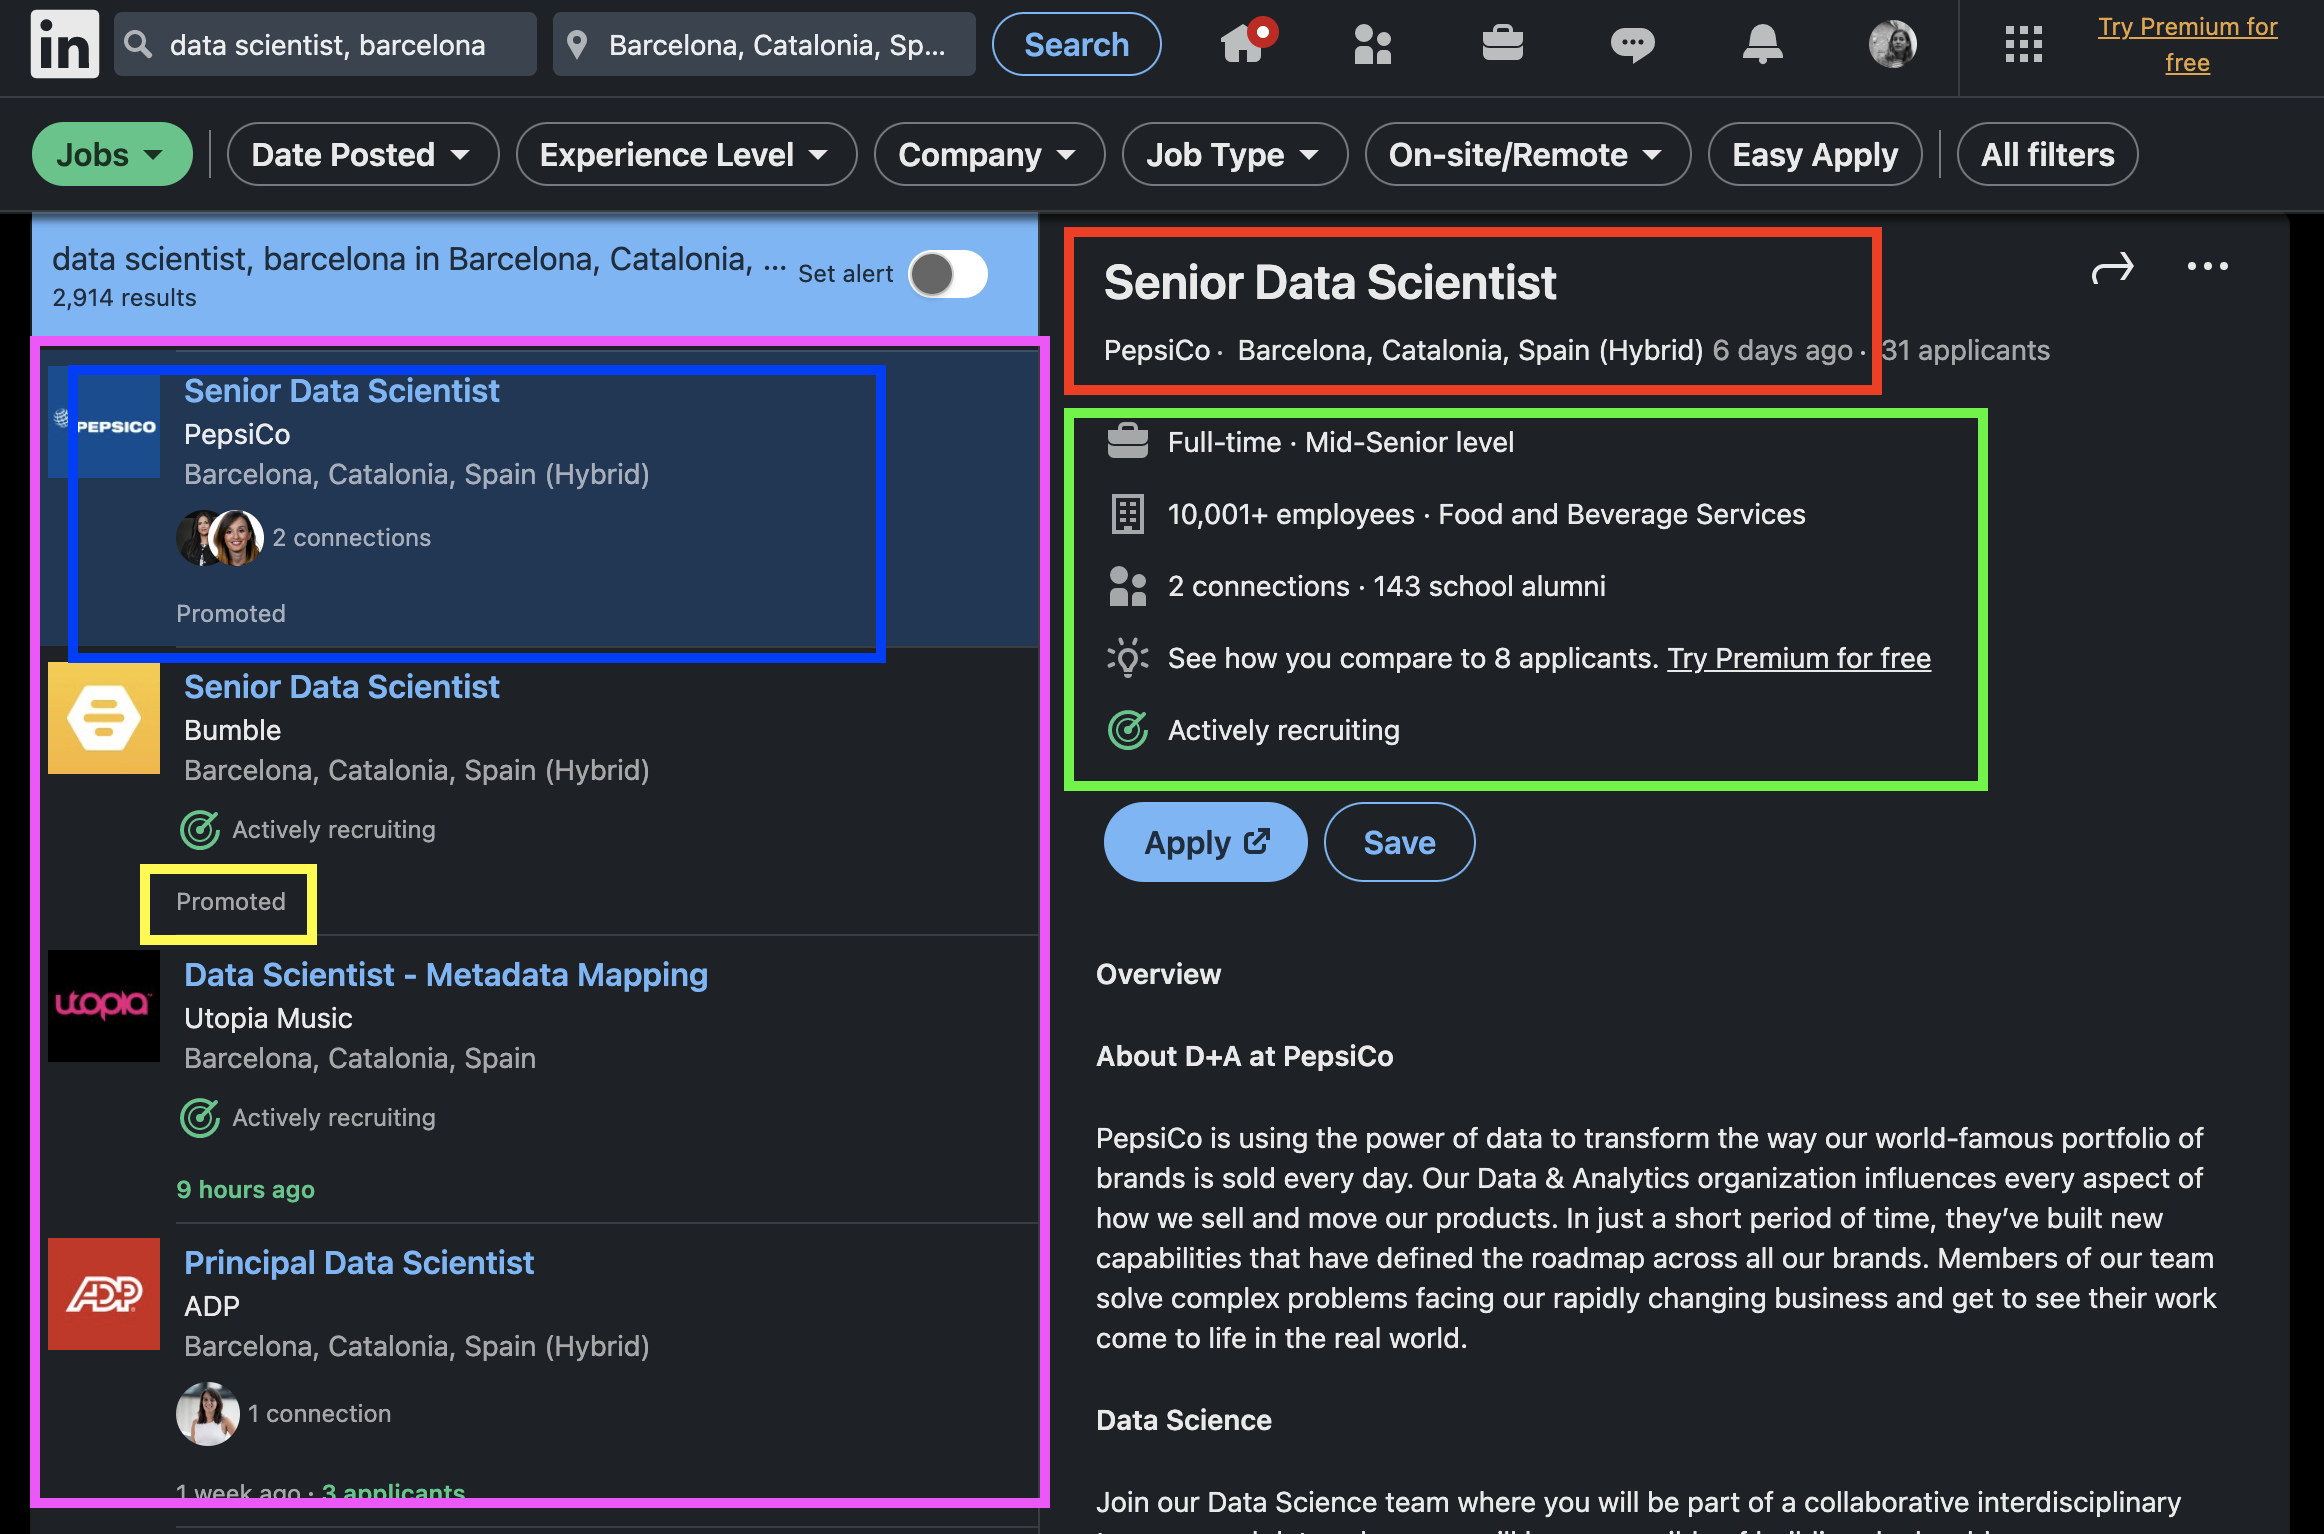

Starting from the left side of the picture: 

- For each page, we will access individual job listings (the blue box, *jobs_list* in our code) from the complete lists of open positions (the pink box, *jobs_block* in our code). 


- From the blue box, we will extract the URL to the job offer and then click it to open the right side of the picture.


- From the footer (the yellow box), we will be able to extract whether the job is being promoted and if it is possible to apply through LinkedIn). 
    
    NOTE: Promoted jobs are positions relevant to the user's profile. Since our dummy profile is quite empty, we 
    are not epecting to find promoted jobs.


Now that we have access to the right side of the picture: 

- From the red box (*content* in our code), we will extract the job title, company name, job location, work methods, and posting date. 


- From the green box (*insights* in our code), we will extract the contract type and level, number of employees, number of applicants, and the status. 

    NOTE 1: the order of the information in the green boxe might change from job to job. For this reason, we will 
    first discard those that we don't need (e.g.: school alumni and who is hiring) and then based on the length of 
    the list, we can figure out which information corresponds to which. Moreover, we created lists of accepted 
    values (all values were taken from LinkedIn itself so they are exhaustive). Through these lists, we can check 
    if a string has the accepted values or not, and if it has at least one accepted value we will be able to sort 
    that string into the list place.
    
    NOTE 2: the status varies from 'actively recruiting' to 'your profile matches the job', however we were asked 
    to find only the status corresponding to 'actively recruiting' and 'be an early applicant' and mark all the 
    others as 'other'. To achieve this, we create a list of accepted values which our code will check whenever 
    there is a status badge. Again, since our profile is quite empty we don't expect to find 'other' status types. 
    
    NOTE 3: based on the example uploaded on the Moodle page, we concluded that for number of employees is 
    sufficient to retrieve the range and then get the highest value.
    

- From the description (the orange box), we will be able to extract the content of the description and later on, in the data cleaning process, figure out whether python is a requirement or not. 

<div class="alert alert-block alert-danger"><b>WARNING:</b> The following cell is quite long to run. It takes time to navigate through the 40 pages and we have also set some time.sleep() to not get banned from the platform.</div>

In [8]:
# Get all links for these offers
links = [] #READY 
promoted_easyapply = [] #TO BE CLEANED
job_titles = [] #TO BE CLEANED
company_names = [] #TO BE CLEANED

company_locations = [] #READY
post_dates = [] #READY
work_methods=[] #READY

# Accepted values for contract, level, and status types (taken from LinkedIn itself).
contract_types = ['full-time', 'part-time', 'contract', 'internship', 'temporary']
level_types = ['internship','entry level', 'associate', 'mid-senior level', 'director', 'executive']
status_types = ['actively recruiting', 'actively hiring', 'early applicant']

contract_level = [] #TO BE CLEANED
employees_industries = [] #TO BE CLEANED
applicants = [] #TO BE CLEANED
status_list = [] #TO BE CLEANED

job_desc = [] #TO BE CLEANED



for page in tqdm(range(2,tot_num_pages+2)):
    try:
        jobs_block = driver.find_element(By.CLASS_NAME,'scaffold-layout__list-container')
        jobs_list= jobs_block.find_elements(By.CSS_SELECTOR, '.jobs-search-results__list-item')

        for job in jobs_list:

            promoted_easyapply.append(job.find_element(By.CLASS_NAME,'job-card-list__footer-wrapper').text)
            all_links = job.find_elements(By.TAG_NAME, "a")

            for a in all_links:

                if str(a.get_attribute('href')).startswith("https://www.linkedin.com/jobs/view") and a.get_attribute('href') not in links: 
                    links.append(a.get_attribute('href'))
                    try:
                        a.click()
                        time.sleep(2)
                        content = driver.find_element(By.CLASS_NAME, 'jobs-unified-top-card__content--two-pane')

                        try: 
                            job_titles.append(content.find_element(By.TAG_NAME,"h2").text)
                        except: 
                            job_titles.append(None)
                        try:
                            company_names.append(content.find_element(By.CLASS_NAME,"jobs-unified-top-card__company-name").text)
                        except:
                            company_names.append(None)
                        try:
                            company_locations.append(content.find_element(By.CLASS_NAME,"jobs-unified-top-card__bullet").text)
                        except:
                            company_locations.append(None)
                        try:
                            post_dates.append(content.find_element(By.CLASS_NAME,"jobs-unified-top-card__posted-date").text) 
                        except:
                            post_dates.append(None)
                        try:  
                            work_methods.append(content.find_element(By.CLASS_NAME,"jobs-unified-top-card__workplace-type").text)
                        except: 
                            work_methods.append(None)


                        insights = content.find_elements(By.CLASS_NAME, 'jobs-unified-top-card__job-insight')
                        i = 0
                        insights_list_cleaned = []
                        for i in range(len(insights)):
                            info = insights[i].text
                            info = info.lower()
                            i +=1
                            if 'school' not in info and 'hiring' not in info and 'matches' not in info and 'poster' not in info:
                                insights_list_cleaned.append(info)

                        if len(insights_list_cleaned) == 4:
                            contract_level.append(insights_list_cleaned[0])
                            employees_industries.append(insights_list_cleaned[1])
                            applicants.append(insights_list_cleaned[2])
                            if any(ele in insights_list_cleaned[3] for ele in status_types):
                                status_list.append(insights_list_cleaned[3])
                            else: 
                                status_list.append('Other')

                        if len(insights_list_cleaned) == 3:
                            if any(ele in insights_list_cleaned[0] for ele in contract_types):
                                contract_level.append(insights_list_cleaned[0])
                                employees_industries.append(insights_list_cleaned[1])
                                if 'applicants' in insights_list_cleaned[2]:
                                    applicants.append(insights_list_cleaned[2])
                                    status_list.append(None)
                                if 'applicants' not in insights_list_cleaned[2]:
                                    applicants.append(None)
                                    if any(ele in insights_list_cleaned[2] for ele in status_types):
                                        status_list.append(insights_list_cleaned[2])
                                    else:
                                        status_list.append('Other')

                            if 'employees' in insights_list_cleaned[0]:
                                contract_level.append(None)
                                employees_industries.append(insights_list_cleaned[0])
                                applicants.append(insights_list_cleaned[1]) 
                                if any(ele in insights_list_cleaned[2] for ele in status_types):
                                    status_list.append(insights_list_cleaned[2])
                                else:
                                    status_list.append('Other')

                        if len(insights_list_cleaned) == 2:
                            if any(ele in insights_list_cleaned[0] for ele in contract_types):
                                contract_level.append(insights_list_cleaned[0])
                                if 'employees' in insights_list_cleaned[1]:
                                    employees_industries.append(insights_list_cleaned[1])
                                    applicants.append(None) 
                                    status_list.append(None)
                                if 'applicants' in insights_list_cleaned[1]:
                                    employees_industries.append(None)
                                    applicants.append(insights_list_cleaned[1]) 
                                    status_list.append(None)
                            if 'employees' in insights_list_cleaned[0]:
                                contract_level.append(None)
                                employees_industries.append(insights_list_cleaned[0])
                                if 'applicants' in insights_list_cleaned[1]:
                                    applicants.append(insights_list_cleaned[1]) 
                                    status_list.append(None)
                                if 'applicants' not in insights_list_cleaned[1]:
                                    applicants.append(None) 
                                    if any(ele in insights_list_cleaned[1] for ele in status_types):
                                        status_list.append(insights_list_cleaned[1])
                                    else:
                                        status_list.append('Other')

                        if len(insights_list_cleaned) == 1:
                            if any(ele in insights_list_cleaned[0] for ele in contract_types):
                                contract_level.append(insights_list_cleaned[0])
                                employees_industries.append(None)
                                applicants.append(None) 
                                status_list.append(None)
                            if 'employees' in insights_list_cleaned[0]:
                                contract_level.append(None)
                                employees_industries.append(insights_list_cleaned[0])
                                applicants.append(None) 
                                status_list.append(None)
                            if 'applicants' in insights_list_cleaned[0]:
                                contract_level.append(None)
                                employees_industries.append(None)
                                applicants.append(insights_list_cleaned[0])
                                status_list.append(None)


                        description = driver.find_element(By.CLASS_NAME,'jobs-description__container')
                        job_desc.append(description.text)

                    except:
                        pass

                else:
                    pass
            # scroll down for each job element
            driver.execute_script("arguments[0].scrollIntoView();", job)

        #print(f'Collecting the links in the page: {page-1}')
        # go to next page:
        driver.find_element('xpath',f"//button[@aria-label='Page {page}']").click()
        time.sleep(1)
    except:
        pass
    


print('Found ' + str(len(links)) + ' links for job offers')

100%|████████████████████████████████████████| 40/40 [2:02:46<00:00, 184.16s/it]

Found 999 links for job offers


In [35]:
#quick test to verify if all data has been collected.

print(len(links))
print(len(promoted_easyapply ))
print(len(job_titles )) 
print(len(company_names ))
print(len(company_locations))
print(len(post_dates ))
print(len(work_methods))


print(len(contract_level))
print(len(employees_industries)) 
print(len(applicants)) 
print(len(status_list )) 

print(len(job_desc)) 

999
999
999
999
999
999
999
999
999
999
999
999


## Data Cleaning

Now that we have all the requested information, it is time to do some data cleaning. Namely:

- We notice that some job listings don't have the company name, but have a blank space. For these cases (which are not detected automatically as None since the class corresponding to the company name is present anyway), we will put a None value.


- From promoted_easyapply, we will extract if the jobs are relevant to our profile (promoted or not) and whether it is possible to apply via LinkedIn itself. Both information will be stored as boolean values. 
    
    
- From contract_level, we will extract the type of contract (full time, part time, etc) and the seniority level (intern, director, etc).


- From employees_industries, we will extract the number of employees and the company's industry type.
        

- From applicants, we will extract the integer.


- From status_list, we will map if the job listing shows the badges "actively hiring/recruiting" as "On-going"  and "be an early applicant" as "Be an early applicant" (all other badges are mapped as "other", already done while scraping).


- From job_desc, we will extract whether Python is a requirement or not. 

    NOTE: Based on the guidelines, Python will be mapped as a requirement if it is simply mentioned in the 
    description. 
    


In [50]:
company_names_cleaned = []
for elem in company_names:
    if elem == '':
        company_names_cleaned.append(None)
    else:
        company_names_cleaned.append(elem)
print(len(company_names_cleaned))

999


In [51]:
promoted = []
easy_apply = []

for x in promoted_easyapply:
    if x == None: 
        promoted.append(False)
        easy_apply.append(False)
    else:
        x = (x.lower()) #to be sure, we will convert everything to lowercase
        if 'easy apply' in x:
            easy_apply.append(True)
        else: 
            easy_apply.append(False)

        if 'promoted' in x:
            promoted.append(True)
        else: 
            promoted.append(False)
        
print(len(promoted))
print(len(easy_apply))

999
999


In [52]:
python_required = []
for x in job_desc:
    if x == None: 
        python_required.append(None)
    else:
        x = (x.lower()) #to not make it case sensitive
        if 'python' in x:
            python_required.append(True)
        else: 
            python_required.append(False)
            
print(len(python_required))

999


In [53]:
import re
applicants_number = []
for elem in applicants: 
    if elem is None: 
        applicants_number.append(None)
    else:
        apps = re.search(r'\d+', elem).group()
        applicants_number.append(int(apps))

print(len(applicants_number))

999


In [54]:
job_industries = []
range_employees = []

for elem in employees_industries:
    if elem == None: 
        job_industries.append(None)
        range_employees.append(None)
    else:
        if ' · ' in elem:
            info = elem.split(' · ')
            job_industries.append(info[1])
            range_employees.append(info[0])
        else:
            job_industries.append(None)
            range_employees.append(elem)
        

number_employees = []
for elem in range_employees:
    if elem == None: 
        number_employees.append(None)
    else:
        empl = elem.split(' employees')[0]
        if '+' in empl: 
            num = empl.split('+')[0]
            if ',' in num: 
                integer = num.replace(',', '')
                number_employees.append(int(integer))
        if '-' in empl:
            num = empl.split('-')[1]
            if ',' in num: 
                num = num.replace(',', '')
                number_employees.append(int(num))
            else: 
                number_employees.append(int(num))

print(len(job_industries))
print(len(number_employees))

999
999


In [55]:
contract_types = []
level_types = []

for elem in contract_level:
    if elem == None:
        contract_types.append(None)
        level_types.append(None)
    else: 
        if ' · ' in elem: 
            info = elem.split(' · ')
            contract_types.append(info[0])
            level_types.append(info[1])
        else:
            contract_types.append(elem)
            level_types.append(None)

print(len(contract_types))
print(len(level_types))

999
999


In [56]:
status_cleaned = []

for elem in status_list:
    if elem == None:
        status_cleaned.append(None)
    else: 
        if any(typ in elem for typ in status_types):
            if 'recruiting' in elem or 'hiring' in elem:
                status_cleaned.append('On-going')
            if 'early' in elem: 
                status_cleaned.append('Early Applications')
        else:
            status_cleaned.append('Other')

print(len(status_cleaned))

999


## DataFrame Creation

We will now put the information scraped into a dataframe for better readability. 

In [16]:
import pandas as pd
import numpy as np

In [57]:
df = pd.DataFrame()
df['Job Title'] = job_titles
df['Company Name'] = company_names_cleaned
df['Location'] = company_locations
df['State'] = status_cleaned
df['Posting Date'] = post_dates
df['Offer URL'] = links
df['Number of Applicants'] = applicants_number
df['Promoted'] = promoted
df['Workspace'] = work_methods
df['Seniority'] = level_types
df['Employment Type'] = contract_types
df['Industry'] = job_industries
df['Python Required']= python_required
df['Application through LinkedIn'] = easy_apply
df['Number of Employees'] = number_employees

In [58]:
pd.options.display.float_format = '{:,.0f}'.format
df = df.fillna(value=np.nan)
df

,Job Title,Company Name,Location,State,Posting Date,Offer URL,Number of Applicants,Promoted,Workspace,Seniority,Employment Type,Industry,Python Required,Application through LinkedIn,Number of Employees
0,Data Scientist - Digital Finance Hub,Novartis España,"Barcelona, Catalonia, Spain",NaN,2 days ago,https://www.linkedin.com/jobs/view/3322861238/...,87,False,NaN,associate,full-time,pharmaceutical manufacturing,True,False,"5,000"
1,Game Data Scientist,Socialpoint,"Barcelona, Catalonia, Spain",On-going,7 hours ago,https://www.linkedin.com/jobs/view/3358075797/...,NaN,False,Hybrid,entry level,full-time,mobile gaming apps,True,False,500
2,Data Scientist Madrid/Barcelona/Gijón,Accenture España,"Barcelona, Catalonia, Spain",On-going,4 days ago,https://www.linkedin.com/jobs/view/3286648063/...,138,False,NaN,mid-senior level,full-time,business consulting and services,True,False,"10,001"
3,DATA SCIENTIST INTEN,MANGO,"Barcelona, Catalonia, Spain",On-going,2 weeks ago,https://www.linkedin.com/jobs/view/3357783024/...,3,False,Hybrid,entry level,full-time,retail apparel and fashion,True,False,"10,001"
4,Data Scientist,PepsiCo,"Barcelona, Catalonia, Spain",On-going,1 week ago,https://www.linkedin.com/jobs/view/3343624705/...,39,False,Hybrid,mid-senior level,full-time,food and beverage services,True,False,"10,001"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,Mid Front-end Developer en React at Mankind Te...,join.com,"Barcelona, Catalonia, Spain",On-going,1 week ago,https://www.linkedin.com/jobs/view/3339096398/...,27,False,On-site,entry level,full-time,software development,False,False,200
995,Desarrollador de Visual Basic,Hays,Spain,On-going,1 week ago,https://www.linkedin.com/jobs/view/3339294802/...,53,False,Remote,mid-senior level,full-time,staffing and recruiting,False,True,"10,000"
996,Software Engineer (embedded),Midokura,"Barcelona, Catalonia, Spain",NaN,3 months ago,https://www.linkedin.com/jobs/view/3177870808/...,19,False,NaN,mid-senior level,full-time,software development,False,False,200
997,Prácticas en Software Engineering con tecnolog...,Avanade,"Barcelona, Catalonia, Spain",On-going,1 day ago,https://www.linkedin.com/jobs/view/3348032630/...,5,False,NaN,entry level,full-time,it services and it consulting,False,False,"10,001"


If you wish, you can also save the dataframe in CSV format.

In [59]:
df.to_csv('data.csv', index=False)

# 2) Logged-out Solution

<div class="alert alert-warning"> <b>NOTE:</b> The following is a backup code if LinkedIn were to ask you a verification code in the previous solution. 
</div>

This is the logged-out solution to the assignement. Moreover, we decided to present a static approach hence we will only scrape the first 25 jobs and not all the information requested can be retrieved while being logged out. Finally, spamnish

Steps:


1. Targeted the home page of "job listings". Sent request on that and on receiving a successful response of "200", we made a soup object of response.


2. We gathered all the individual job pages "urls" and their states. Then, we saved them in a "list" and "data dictionary" respectively.


3. We looped through each individual page and created the soup of each page.


4. We searched all the individual elements available without logging in (we  got 12 elements from 15). Promotion, Workspace and Number of Employees can't be retrieved.


5. For the "Application through LinkedIn" variable, if the text on the button is simply 'apply' then we assumed that it is through LinkedIn otherwise its not.


6. If any element was "not found" then we set it to "NaN", otherwise we added in the data dictionary.


7. Finally, once the dictionary was fully populated, we converted it to the dataframe to display the final result.

<div class="alert alert-warning"> <b>NOTE:</b>  We will use the link attached in the assignment moodle page, thus
    we will access the Spanish version of LinkedIn</div>

In [63]:
### importing the tools
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import time

data_dict = {'Job Title': [],
            'Company Name': [], 
            'Location': [], 
            'State': [],
            'Posting Date': [], 
            'Offer URL' : [],
            'Number of Applicants': [],
            'Promoted': [],
            'Workspace' : [],
            'Seniority' : [],
            'Employment Type': [],
            'Industry' : [],
            'Python Required' : [],
            'Application through Linkedin': [],
            'Number of Employees' : [], 
             }

### getting the main job listings page

url = 'https://www.linkedin.com/jobs/search/?currentJobId=3270287326&amp;geoId=107025191&amp;keywords=data%20scientist%2C%20barcelona&amp;location=Barcelona%2C%20Catalonia%2C%20Spain&amp;refresh=true'
response = requests.get(url)

if response.status_code != 200:
    print('Got error or page not found.')
else:
    content = response.text


### soup object for the main page
soup = BeautifulSoup(content, 'html.parser')


### gather all the available job  links to open them later
job_posters = soup.find_all('a', {'class':'base-card__full-link absolute top-0 right-0 bottom-0 left-0 p-0 z-[2]'})


all_cards = soup.find_all('div', {'class': 'base-search-card__info'})

for card in all_cards:
    try:
        state = card.find('span', {'class': 'result-benefits__text'}).get_text().strip()
    except:
        state = 'other'
    
    if state == 'Actively Hiring':
        data_dict['State'].append('On-going')
    elif state == 'Be an early applicant':
        data_dict['State'].append('Early Applications')
    else:
        data_dict['State'].append('Others')


job_links = []
for poster in job_posters:
    job_links.append(poster.get('href'))

i = 1
### go through each page at a time and scrape the required data
for page_url in job_links:
    time.sleep(2)
  
    print('Job number =',i,  'Information for', page_url)
    content_page = requests.get(page_url).text
    soup_page = BeautifulSoup(content_page, 'html.parser')

    try:
        item = soup_page.find('a')
    except:
        print('URL Error, skipping.....')
        continue

  
    company_name = soup_page.find('a', {'class':'topcard__org-name-link topcard__flavor--black-link'}).get_text().strip()


    job_title = soup_page.find('h1', {'class':'top-card-layout__title font-sans text-lg papabear:text-xl font-bold leading-open text-color-text mb-0 topcard__title'}).get_text()
    location = soup_page.find('span', {'class':'topcard__flavor topcard__flavor--bullet'}).get_text().strip()
    date = soup_page.find('span', {'class':'topcard__flavor--metadata'}).get_text().strip()
    try:
        applicants = soup_page.find('span', {'class': 'num-applicants__caption topcard__flavor--metadata topcard__flavor--bullet'}).get_text().strip()
        n_applicants = ''
        for letter in applicants:
            if letter.isnumeric():
                n_applicants += letter
                n_applicants = int(n_applicants)
    except:
        n_applicants = np.nan

    try:
        seniority = soup_page.find_all('span', {'class': 'description__job-criteria-text description__job-criteria-text--criteria'})[0].get_text().strip()
        emp_type = soup_page.find_all('span', {'class': 'description__job-criteria-text description__job-criteria-text--criteria'})[1].get_text().strip()
        industry = soup_page.find_all('span', {'class': 'description__job-criteria-text description__job-criteria-text--criteria'})[3].get_text().strip()
    except:
        seniority = np.nan
        emp_type = np.nan
        industry = np.nan
    desc = soup_page.find('div', {'class': 'show-more-less-html__markup show-more-less-html__markup--clamp-after-5'}).get_text()
    python_found = 'python' in desc.lower()

    try:
        apply_button_text = soup_page.find('a', {'class': 'apply-button apply-button--link top-card-layout__cta mt-2 ml-1.5 h-auto babybear:flex-auto top-card-layout__cta--primary btn-md btn-primary'}).get_text().strip()
    except:
        apply_button_text = soup_page.find('button', {'class': 'apply-button apply-button--default top-card-layout__cta mt-2 ml-1.5 h-auto babybear:flex-auto top-card-layout__cta--primary btn-md btn-primary'}).get_text().strip()
  ### if text on the button is simply 'apply' then we assume that its through linkedin otherwise its not. (without logging in)
    if apply_button_text == 'Solicitar en el sitio web de la empresa':
        through_linked_in = False
    else:
        through_linked_in = True

    i += 1

  

    data_dict['Job Title'].append(job_title)
    data_dict['Company Name'].append(company_name)
    data_dict['Location'].append(location)
    data_dict['Posting Date'].append(date)
    data_dict['Offer URL'].append(page_url)
    data_dict['Number of Applicants'].append(n_applicants)
    data_dict['Promoted'].append(np.nan)
    data_dict['Workspace'].append(np.nan)
    data_dict['Seniority'].append(seniority)
    data_dict['Employment Type'].append(emp_type)
    data_dict['Industry'].append(industry)
    data_dict['Python Required'].append(python_found)
    data_dict['Application through Linkedin'].append(through_linked_in)
    data_dict['Number of Employees'].append(np.nan)



    
final_data  = pd.DataFrame(data_dict)
final_data


Job number = 1 Information for https://es.linkedin.com/jobs/view/data-scientist-at-grupo-planeta-3349546345?refId=jWI3ASuxVTRJR9dVWUR8lg%3D%3D&trackingId=f4whZ%2BMBIFsWZgTcFMdctg%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card
Job number = 2 Information for https://es.linkedin.com/jobs/view/data-scientist-at-swissborg-3357046633?refId=jWI3ASuxVTRJR9dVWUR8lg%3D%3D&trackingId=th2YJKKSGhTgrqhbo37piA%3D%3D&position=2&pageNum=0&trk=public_jobs_jserp-result_search-card
Job number = 3 Information for https://es.linkedin.com/jobs/view/data-scientist-machine-learning-engineer-at-mango-3327318389?refId=jWI3ASuxVTRJR9dVWUR8lg%3D%3D&trackingId=GHPAsLG5wZfJRXT5rmq0nw%3D%3D&position=3&pageNum=0&trk=public_jobs_jserp-result_search-card
Job number = 4 Information for https://es.linkedin.com/jobs/view/ml-engineer-conversation-ai-at-crowd-media-3325255431?refId=jWI3ASuxVTRJR9dVWUR8lg%3D%3D&trackingId=WWGx%2Fs%2FrXabJUiUjse%2Bx%2Bg%3D%3D&position=4&pageNum=0&trk=public_jobs_jserp-resu

,Job Title,Company Name,Location,State,Posting Date,Offer URL,Number of Applicants,Promoted,Workspace,Seniority,Employment Type,Industry,Python Required,Application through Linkedin,Number of Employees
0,Data Scientist,Grupo Planeta,Barcelona,On-going,Hace 1 semana,https://es.linkedin.com/jobs/view/data-scienti...,NaN,NaN,NaN,Algo de responsabilidad,Jornada completa,Edición y publicación en publicaciones periódi...,False,True,NaN
1,Data Scientist,SwissBorg,Barcelona,Early Applications,Hace 13 horas,https://es.linkedin.com/jobs/view/data-scienti...,NaN,NaN,NaN,Sin experiencia,Jornada completa,Servicios financieros,True,False,NaN
2,Data Scientist- Machine Learning Engineer,MANGO,Palau-solità i Plegamans,On-going,Hace 3 semanas,https://es.linkedin.com/jobs/view/data-scienti...,NaN,NaN,NaN,Intermedio,Jornada completa,Industria textil y moda para la venta minorista,True,True,NaN
3,ML Engineer (Conversation AI),Crowd Media,Barcelona,Early Applications,Hace 1 mes,https://es.linkedin.com/jobs/view/ml-engineer-...,NaN,NaN,NaN,No corresponde,Jornada completa,"Tecnología, información e internet",True,True,NaN
4,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Barcelona,On-going,Hace 1 día,https://es.linkedin.com/jobs/view/junior-data-...,NaN,NaN,NaN,Sin experiencia,Jornada completa,Petróleo y gas,True,False,NaN
5,Data Scientist (Andorra),Gauss & Neumann,Barcelona,On-going,Hace 1 semana,https://es.linkedin.com/jobs/view/data-scienti...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN
6,Data Scientist,Scalapay,Barcelona,Others,Hace 5 días,https://es.linkedin.com/jobs/view/data-scienti...,NaN,NaN,NaN,Sin experiencia,Jornada completa,Servicios financieros,True,False,NaN
7,Data Scientist (She/He/They),Volotea,Barcelona,Others,Hace 1 semana,https://es.linkedin.com/jobs/view/data-scienti...,NaN,NaN,NaN,No corresponde,Jornada completa,Aeronáutica y aviación,True,False,NaN
8,Principal Data Scientist,Experfy,Barcelona,Early Applications,Hace 1 mes,https://es.linkedin.com/jobs/view/principal-da...,NaN,NaN,NaN,No corresponde,Contrato por obra,"Tecnología, información e internet",True,True,NaN
9,Data Scientist,Roche,Barcelona,On-going,Hace 8 horas,https://es.linkedin.com/jobs/view/data-scienti...,NaN,NaN,NaN,Algo de responsabilidad,Jornada completa,"Fabricación de equipamiento médico, Biotecnolo...",True,False,NaN


In [64]:
final_data.to_csv('data_1.csv', index=False)